In [1]:
coordinates=[]

mapit = None

testfile = pygeoj.load(filepath="../data/map.geojson")

mapit = folium.Map( location=[45.19338, 11.31001], zoom_start=22 )

for feature in testfile:
  for coord in feature.geometry.coordinates:
    
    coordinates.append(coord)

for lat_long in coordinates:
  
  folium.Marker([lat_long[1],lat_long[0]]).add_to( mapit )
    
    

11.311228
11.3111418
11.3102231
11.3094997
11.3102231
11.3100634
11.3093479
11.3100634
11.309183
11.3092426
11.3096537
11.3097735
11.3092277
11.3096519
11.3099051
11.3108218
11.3109077
11.3110941
11.3116047
11.3113707
11.3112177
11.3111246
11.3110941
11.3100634
11.3109112
11.3112177
11.3097735
11.3099051
11.3100634
11.3092277
11.3093479
11.3094997
11.3097311
11.3100668
11.3111853
11.310781
11.3105572
11.3096537
11.3097735
11.3103278
11.3108375
11.310781
11.3108375
11.3109077


In [6]:
mapit

In [7]:
mapit.save( 'map.html')

In [25]:
import overpass

api = overpass.API()

way_query = overpass.WayQuery('')
response = api.Get(way_query)

print(response)

{"features": [{"geometry": {"coordinates": [-86.8633749, 38.8239365], "type": "Point"}, "id": 180474047, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [-86.8630421, 38.8234091], "type": "Point"}, "id": 180474051, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [-86.8625367, 38.8229201], "type": "Point"}, "id": 180474058, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [-86.862305, 38.8226524], "type": "Point"}, "id": 180474064, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [-86.8617063, 38.8215898], "type": "Point"}, "id": 180474066, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [-110.0050035, 51.85257], "type": "Point"}, "id": 2589902678, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [-108.5, 51.9398692], "type": "Point"}, "id": 2608943941, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [-108.4611382, 51.9398734], "type": "Point"}, "id": 2608943

In [182]:
import numpy as np
import pygeoj
import folium
from scipy.interpolate import interp1d
import math
import utm
import matplotlib.pyplot as plt

class Map:
    
    def __init__(self):
        self.map = []
        self.testfile= []
        self.vector_map= []
        
    def load_map(self, path):
        
        testfile = pygeoj.load(filepath=path)
        
        for feature in testfile:
            self.map.append(feature.geometry.coordinates)
                
        return self.map
    
    def harvesine_distance_lat_long(self,lat0,lon0,lat1,lon1):
        R = 6371 # raggio terra in metri
        lat0rad=math.radians(lat0)
        lat1rad=math.radians(lat1)
        DeltaLat=math.radians(lat1-lat0)
        DeltaLon=math.radians(lon1-lon0)
        a= (math.sin(DeltaLat/2) * math.sin(DeltaLat/2)) + (math.cos(lat0rad) * math.cos(lat1rad) * math.sin(DeltaLon/2)*math.sin(DeltaLon/2))
        c= 2 * math.atan2(math.sqrt(a),math.sqrt(1-a))
        dist= (R * c)*1000
        dist= round(dist,2)
        
        return dist
    
    def distance_utm_lat_long(self,lat0,lon0,lat1,lon1):
        x0,y0,n,b = utm.from_latlon(lat0,lon0)
        x1,y1,n,b = utm.from_latlon(lat1,lon1)
        
        dist = math.sqrt((pow(x1-x0,2)+pow(y1-y0,2)))
        return dist
    
    def distance_two_points(self,x0,y0,x1,y1):
        dist=math.sqrt((pow(x1-x0,2)+pow(y1-y0,2)))
        return dist
    
    def theta_two_points(self,x0,y0,x1,y1):
        theta = math.atan2(y1 - y0, x1 - x0);
        if (theta < 0.0):
            theta += 2*math.pi
        return theta
        
    def create_vector_map(self, meter_step):
        
        for element in self.map:
            #print(element)
            for i in range(1,len(element)):
                lat0= element[i-1][1]
                lon0= element[i-1][0]
                lat1= element[i][1]
                lon1= element[i][0]
                x0,y0,n,b=utm.from_latlon(lat0,lon0)
                self.vector_map.append((x0,y0,n,b,))
                x1,y1,n,b=utm.from_latlon(lat1,lon1)
                #dist_harvesine=self.harvesine_distance_lat_long(lat0,lon0,lat1,lon1)  
                dist_utm=self.distance_utm_lat_long(lat0,lon0,lat1,lon1)
                #print(utm.from_latlon(lat0,lon0),utm.from_latlon(lat1,lon1),dist_harvesine, dist_utm)
                theta = self.theta_two_points(x0,y0,x1,y1)
                if (theta < 0.0):
                    theta += 2*math.pi
                self.vector_map.append((x0,y0,n,b,theta))
                x_prev=x0
                y_prev=y0
                for i in range(int(dist_utm)):
                    new_x = x_prev + meter_step * math.cos(theta)
                    new_y = y_prev + meter_step * math.sin(theta)
                    #print(x_prev,y_prev,new_x,new_y, self.distance_two_points(x_prev,y_prev,new_x,new_y), self.theta_two_points(x_prev,y_prev,new_x,new_y))
                    self.vector_map.append((new_x,new_y,n,b,self.theta_two_points(x_prev,y_prev,new_x,new_y)))
                    x_prev=new_x
                    y_prev=new_y
    
    
    def plot_utm(self):
        x=[]
        y=[]
        
        for element in self.vector_map:
            x.append(element[0])
            y.append(element[1])
            #print(element[0],element[1])
        
        plt.plot(y, x, 'ro')
        plt.axis([min(y), max(y), min(x), max(x)])
        plt.show()
        
        return
        
                
    
        

    def output_html_map(self, fileName):
        
        mapit = folium.Map( location=[45.19338, 11.31001], zoom_start=22 )
        
        for element in self.map:
            for coord in element:
                folium.Marker(([coord[1],coord[0]])).add_to( mapit )
            
        mapit.save( fileName )
        
        return mapit
    
    def output_html_utm_map(self, fileName):
        
        mapit = folium.Map( location=[45.19338, 11.31001], zoom_start=22 )
        for element in self.vector_map:
                
                coord= utm.to_latlon(element[0],element[1],element[2],element[3])
                folium.Marker(([coord[0],coord[1]])).add_to( mapit )
            
        mapit.save( fileName )
        
        return mapit

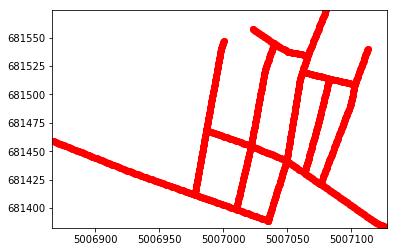

In [185]:
Mappa = Map()

Mappa.load_map("../data/map.geojson")

Mappa.create_vector_map(1)
               
mapit = Mappa.output_html_utm_map("map.html")

#mapit2 = Mappa.output_html_map("map.html")

Mappa.plot_utm()



In [184]:
mapit

In [178]:
mapit2